# Exercise 3

## Imports

In [2]:
# !pip install -r requirements.txt

In [3]:
import time
import os
import optuna
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, balanced_accuracy_score
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

C:\Users\Korisnik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading

In [4]:
ag_news_train_df = pd.read_csv('data/ag_news_train.csv')
ag_news_test_df = pd.read_csv('data/ag_news_test.csv')
amazon_reviews_df = pd.read_csv('data/cleaned_amazon_reviews.csv')

In [5]:
ag_news_train_df.shape

(120000, 3)

In [6]:
ag_news_test_df.shape

(7600, 3)

In [7]:
ag_news_train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [8]:
amazon_reviews_df.shape

(17340, 4)

In [9]:
amazon_reviews_df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [10]:
amazon_reviews_df.isna().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

<AxesSubplot: >

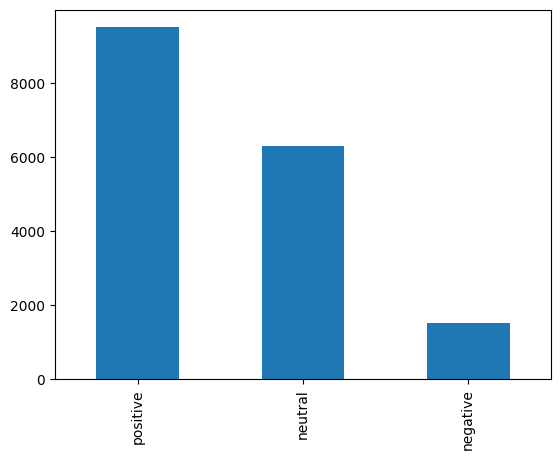

In [11]:
amazon_reviews_df.sentiments.value_counts().plot(kind='bar')

Unbalanced target

<AxesSubplot: >

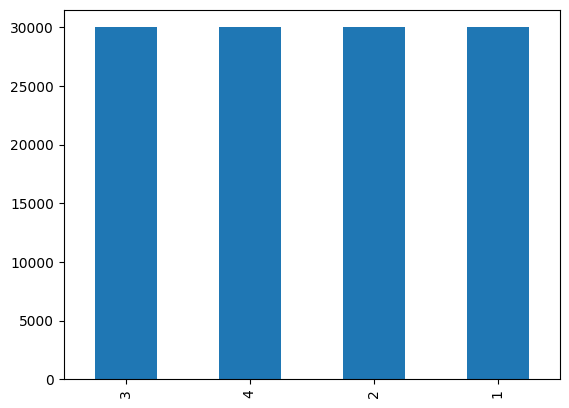

In [12]:
ag_news_train_df['Class Index'].value_counts().plot(kind='bar')

Balanced target

#### Distribution of review lengths

(array([1.4993e+04, 1.8380e+03, 3.4300e+02, 8.3000e+01, 5.0000e+01,
        1.2000e+01, 9.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  0. ,  57.1, 114.2, 171.3, 228.4, 285.5, 342.6, 399.7, 456.8,
        513.9, 571. ]),
 <BarContainer object of 10 artists>)

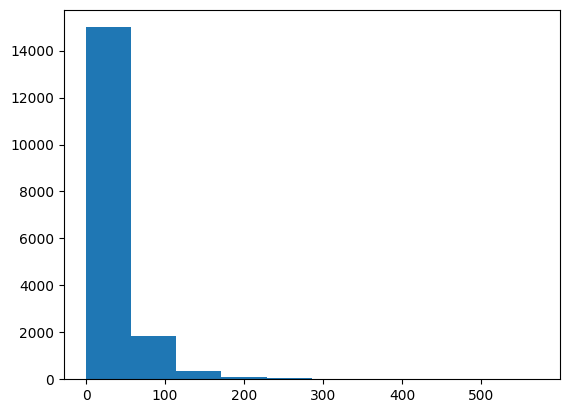

In [13]:
plt.hist(amazon_reviews_df.cleaned_review_length)

#### Distribution of the news article lengths

(array([4.8100e+03, 6.7638e+04, 4.1664e+04, 4.2770e+03, 1.0700e+03,
        2.9800e+02, 9.3000e+01, 9.0000e+01, 2.9000e+01, 3.1000e+01]),
 array([  6. , 103.9, 201.8, 299.7, 397.6, 495.5, 593.4, 691.3, 789.2,
        887.1, 985. ]),
 <BarContainer object of 10 artists>)

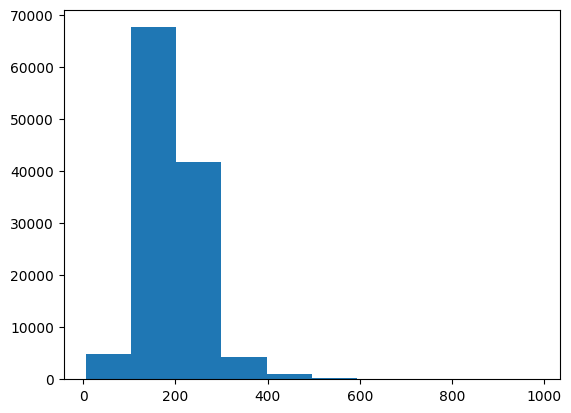

In [14]:
plt.hist(ag_news_train_df.Description.str.len())

In [15]:
ag_news_train_df.isna().any()

Class Index    False
Title          False
Description    False
dtype: bool

#### Removing NaNs

In [16]:
amazon_reviews_df.dropna(inplace=True)

### Splitting amazon reviews into train and test set

In [17]:
X_amazon_reviews = amazon_reviews_df.drop(columns=['sentiments'])
y_amazon_reviews = amazon_reviews_df['sentiments']

In [18]:
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_amazon_reviews,
                                                                                   y_amazon_reviews,
                                                                                   random_state=42,
                                                                                   test_size=0.2)

In [19]:
X_train_reviews, X_valid_reviews, y_train_reviews, y_valid_reviews = train_test_split(X_train_reviews,
                                                                                     y_train_reviews,
                                                                                     random_state=42,
                                                                                     test_size = 0.33)

### Splitting ag news into X and y's

Merging Title and Description into one field, "Text"

In [20]:
ag_news_train_df['Text'] = ag_news_train_df[['Title', 'Description']].agg(' '.join,axis=1)
ag_news_test_df['Text'] = ag_news_test_df[['Title', 'Description']].agg(' '.join,axis=1)

In [21]:
ag_news_train_df['Text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Text, Length: 120000, dtype: object

In [22]:
X_train_news = ag_news_train_df['Text']
y_train_news = ag_news_train_df['Class Index']

X_test_news = ag_news_test_df['Text']
y_test_news = ag_news_test_df['Class Index']

In [23]:
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news,
                                                                          y_train_news,
                                                                          random_state=42,
                                                                          test_size = 0.33)

## Naive feature extraction

### Uni-Bigram vectorizer

Because documents are quite short on average, we used the uni-bigram vectorizer (contains both unigrams and bigrams)

Following pieces of code were taken from Sklearn's text feature extraction tutorial. (https://scikit-learn.org/stable/modules/feature_extraction.html)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
bigram_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r'\b\w+\b', min_df=1)

In [26]:
X_train_reviews_tr = bigram_vectorizer.fit_transform(X_train_reviews.cleaned_review)
X_valid_reviews_tr = bigram_vectorizer.transform(X_valid_reviews.cleaned_review)
X_test_reviews_tr = bigram_vectorizer.transform(X_test_reviews.cleaned_review)

In [27]:
bigram_vectorizer.get_feature_names_out()

array(['a', 'a bit', 'a bunch', ..., 'zoom while', 'zooms', 'zooms down'],
      dtype=object)

In [28]:
X_train_news_tr = bigram_vectorizer.fit_transform(X_train_news)
X_valid_news_tr = bigram_vectorizer.transform(X_valid_news)
X_test_news_tr = bigram_vectorizer.transform(X_test_news)

## Training shallow models

Balanced accuracy score is used to macro average across classes.

For hyperparam tuning only a half of training data will be used for performance reasons.

In [29]:
np.random.seed(42)
reviews_train_idx = np.random.choice(y_train_reviews.shape[0], 
                                     replace=False, size=y_train_reviews.shape[0]//2)
news_train_idx = np.random.choice(y_train_news.shape[0], 
                                     replace=False, size=y_train_news.shape[0]//16)
news_train_eighth_idx = np.random.choice(y_train_news.shape[0], 
                                     replace=False, size=y_train_news.shape[0]//8)

In [30]:
X_train_reviews_half = X_train_reviews_tr[reviews_train_idx,:]
y_train_reviews_half = y_train_reviews.iloc[reviews_train_idx]

X_train_news_16th = X_train_news_tr[news_train_idx,:]
y_train_news_16th = y_train_news.iloc[news_train_idx]

X_train_news_8th = X_train_news_tr[news_train_idx,:]
y_train_news_8th = y_train_news.iloc[news_train_idx]

#### Checking if models are saved

In [31]:
best_model_nn_reviews_is_saved = os.path.exists('models/best_model_nn_reviews.sav')
best_model_nn_news_is_saved = os.path.exists('models/best_model_nn_news.sav')
best_model_svm_reviews_is_saved = os.path.exists('models/best_model_svm_reviews.sav')
best_model_svm_news_is_saved = os.path.exists('models/best_model_svm_news.sav')


### Shallow NN (One layer perceptron)

#### Reviews dataset

In [75]:
available_activations = ['relu', 'logistic', 'tanh']
available_solvers = ['adam', 'lbfgs']
def objective(trial: optuna.trial.Trial):
    size_of_hidden_layer = trial.suggest_int('size_of_hidden_layer', 10, 100)
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    activation = trial.suggest_categorical('activation', 
                                           choices=available_activations)
    solver = trial.suggest_categorical('solver', 
                                           choices=available_solvers)
    
    print(f"Trying: {size_of_hidden_layer}, {alpha}, {activation}, {solver}")
    model = MLPClassifier(hidden_layer_sizes=tuple([size_of_hidden_layer]),
                          alpha=alpha,
                          activation = activation,
                          max_iter=20,
                          solver=solver,
                          verbose=True,
                          learning_rate='adaptive',
                          random_state=42)
    model.fit(X_train_reviews_half, y_train_reviews_half)
    y_pred_probas = model.predict_proba(X_valid_reviews_tr)
    return log_loss(y_valid_reviews, y_pred_probas)


if not best_model_nn_reviews_is_saved:
    study_nn_reviews = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_nn_reviews.optimize(objective, n_trials=10,show_progress_bar=True,n_jobs=-1)

    study_nn_reviews.best_params

[I 2023-02-05 13:48:47,638] A new study created in memory with name: no-name-397be9bd-4d7f-468d-b86a-364104df3ea1
D:\Anaconda\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

Trying: 85, 0.00045434026867030927, logistic, adam
Iteration 1, loss = 0.92028524
Iteration 2, loss = 0.71455394
Iteration 3, loss = 0.58552963
Iteration 4, loss = 0.48101697
Iteration 5, loss = 0.39612572
Iteration 6, loss = 0.32743369
Iteration 7, loss = 0.27259543
Iteration 8, loss = 0.22896768
Iteration 9, loss = 0.19406110
Iteration 10, loss = 0.16665226
Iteration 11, loss = 0.14426509
Iteration 12, loss = 0.12638542
Iteration 13, loss = 0.11170848
Iteration 14, loss = 0.09944469
Iteration 15, loss = 0.08923645
Iteration 16, loss = 0.08053489
Iteration 17, loss = 0.07321025
Iteration 18, loss = 0.06693736
Iteration 19, loss = 0.06148582


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.05678225
[I 2023-02-05 13:51:05,339] Trial 0 finished with value: 0.5408916314788293 and parameters: {'size_of_hidden_layer': 85, 'alpha': 0.00045434026867030927, 'activation': 'logistic', 'solver': 'adam'}. Best is trial 0 with value: 0.5408916314788293.
Trying: 41, 0.00013807745517749806, tanh, adam
Iteration 1, loss = 0.85266920
Iteration 2, loss = 0.43635719
Iteration 3, loss = 0.27191150
Iteration 4, loss = 0.18239756
Iteration 5, loss = 0.13014789
Iteration 6, loss = 0.09656037
Iteration 7, loss = 0.07451130
Iteration 8, loss = 0.05911680
Iteration 9, loss = 0.04806149
Iteration 10, loss = 0.03974461
Iteration 11, loss = 0.03355191
Iteration 12, loss = 0.02867714
Iteration 13, loss = 0.02470266
Iteration 14, loss = 0.02149854
Iteration 15, loss = 0.01893473
Iteration 16, loss = 0.01679686
Iteration 17, loss = 0.01501595
Iteration 18, loss = 0.01349021
Iteration 19, loss = 0.01218883


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.01110159
[I 2023-02-05 13:52:15,450] Trial 1 finished with value: 0.7279103575563545 and parameters: {'size_of_hidden_layer': 41, 'alpha': 0.00013807745517749806, 'activation': 'tanh', 'solver': 'adam'}. Best is trial 0 with value: 0.5408916314788293.
Trying: 16, 0.0005303299081596096, tanh, adam
Iteration 1, loss = 0.95444687
Iteration 2, loss = 0.63526017
Iteration 3, loss = 0.45272070
Iteration 4, loss = 0.34010973
Iteration 5, loss = 0.26445991
Iteration 6, loss = 0.21115410
Iteration 7, loss = 0.17242862
Iteration 8, loss = 0.14318959
Iteration 9, loss = 0.12077597
Iteration 10, loss = 0.10325990
Iteration 11, loss = 0.08926454
Iteration 12, loss = 0.07792834
Iteration 13, loss = 0.06864171
Iteration 14, loss = 0.06091880
Iteration 15, loss = 0.05444944
Iteration 16, loss = 0.04886634
Iteration 17, loss = 0.04412831
Iteration 18, loss = 0.04002093
Iteration 19, loss = 0.03652891


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.03351477
[I 2023-02-05 13:52:45,133] Trial 2 finished with value: 0.6035128154307082 and parameters: {'size_of_hidden_layer': 16, 'alpha': 0.0005303299081596096, 'activation': 'tanh', 'solver': 'adam'}. Best is trial 0 with value: 0.5408916314788293.
Trying: 86, 0.0003446809935603709, tanh, lbfgs


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[I 2023-02-05 13:53:11,424] Trial 3 finished with value: 0.7058967124680039 and parameters: {'size_of_hidden_layer': 86, 'alpha': 0.0003446809935603709, 'activation': 'tanh', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5408916314788293.
Trying: 22, 0.0007533860783720613, relu, adam
Iteration 1, loss = 0.93919562
Iteration 2, loss = 0.63623564
Iteration 3, loss = 0.43169883
Iteration 4, loss = 0.30729512
Iteration 5, loss = 0.22428470
Iteration 6, loss = 0.16937701
Iteration 7, loss = 0.13289026
Iteration 8, loss = 0.10673923
Iteration 9, loss = 0.08774746
Iteration 10, loss = 0.07340813
Iteration 11, loss = 0.06243118
Iteration 12, loss = 0.05365720
Iteration 13, loss = 0.04667331
Iteration 14, loss = 0.04095877
Iteration 15, loss = 0.03628847
Iteration 16, loss = 0.03230561
Iteration 17, loss = 0.02899896
Iteration 18, loss = 0.02613470
Iteration 19, loss = 0.02373501


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.02161391
[I 2023-02-05 13:53:49,228] Trial 4 finished with value: 0.7042450992335587 and parameters: {'size_of_hidden_layer': 22, 'alpha': 0.0007533860783720613, 'activation': 'relu', 'solver': 'adam'}. Best is trial 0 with value: 0.5408916314788293.
Trying: 28, 0.0006355756806095155, tanh, lbfgs


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[I 2023-02-05 13:53:58,074] Trial 5 finished with value: 0.5837894336662457 and parameters: {'size_of_hidden_layer': 28, 'alpha': 0.0006355756806095155, 'activation': 'tanh', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5408916314788293.
Trying: 43, 0.0003782753513655436, relu, adam
Iteration 1, loss = 0.94568234
Iteration 2, loss = 0.57210667
Iteration 3, loss = 0.35290387
Iteration 4, loss = 0.23374824
Iteration 5, loss = 0.16162461
Iteration 6, loss = 0.11683404
Iteration 7, loss = 0.08808520
Iteration 8, loss = 0.06826585
Iteration 9, loss = 0.05462599
Iteration 10, loss = 0.04440412
Iteration 11, loss = 0.03678626
Iteration 12, loss = 0.03093017
Iteration 13, loss = 0.02636853
Iteration 14, loss = 0.02265409
Iteration 15, loss = 0.01971413
Iteration 16, loss = 0.01729711
Iteration 17, loss = 0.01534195
Iteration 18, loss = 0.01366988
Iteration 19, loss = 0.01224607


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.01103966
[I 2023-02-05 13:55:18,768] Trial 6 finished with value: 0.7983532903936058 and parameters: {'size_of_hidden_layer': 43, 'alpha': 0.0003782753513655436, 'activation': 'relu', 'solver': 'adam'}. Best is trial 0 with value: 0.5408916314788293.
Trying: 61, 0.00033242423979699595, relu, lbfgs


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[I 2023-02-05 13:55:37,275] Trial 7 finished with value: 0.699316478897935 and parameters: {'size_of_hidden_layer': 61, 'alpha': 0.00033242423979699595, 'activation': 'relu', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5408916314788293.
Trying: 27, 0.0004108320941920793, tanh, lbfgs


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[I 2023-02-05 13:55:45,760] Trial 8 finished with value: 0.7298626602612078 and parameters: {'size_of_hidden_layer': 27, 'alpha': 0.0004108320941920793, 'activation': 'tanh', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5408916314788293.
Trying: 57, 0.0005189715691190517, logistic, lbfgs


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[I 2023-02-05 13:56:03,558] Trial 9 finished with value: 0.5693811590145404 and parameters: {'size_of_hidden_layer': 57, 'alpha': 0.0005189715691190517, 'activation': 'logistic', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5408916314788293.


{'size_of_hidden_layer': 85,
 'alpha': 0.00045434026867030927,
 'activation': 'logistic',
 'solver': 'adam'}

{'size_of_hidden_layer': 85,
 'alpha': 0.00045434026867030927,
 'activation': 'logistic',
 'solver': 'adam'}

In [77]:
if not best_model_nn_reviews_is_saved:
    best_model_nn_reviews = MLPClassifier(hidden_layer_sizes=(85,), 
                              alpha=0.00045434026867030927,
                              solver='adam',
                              activation='logistic',
                                random_state=42,
                               learning_rate='adaptive',
                               verbose=True,
                              max_iter=50,
                          )
    best_model_nn_reviews.fit(X_train_reviews_tr, y_train_reviews)


Iteration 1, loss = 0.85204182
Iteration 2, loss = 0.60728027
Iteration 3, loss = 0.44798095
Iteration 4, loss = 0.32897192
Iteration 5, loss = 0.24530914
Iteration 6, loss = 0.18774814
Iteration 7, loss = 0.14743751
Iteration 8, loss = 0.11937067
Iteration 9, loss = 0.09848032
Iteration 10, loss = 0.08324523
Iteration 11, loss = 0.07132085
Iteration 12, loss = 0.06231173
Iteration 13, loss = 0.05506250
Iteration 14, loss = 0.04923954
Iteration 15, loss = 0.04447541
Iteration 16, loss = 0.04050258
Iteration 17, loss = 0.03721316
Iteration 18, loss = 0.03442405
Iteration 19, loss = 0.03195646
Iteration 20, loss = 0.02990044
Iteration 21, loss = 0.02806770
Iteration 22, loss = 0.02647645
Iteration 23, loss = 0.02505352
Iteration 24, loss = 0.02379337
Iteration 25, loss = 0.02267507
Iteration 26, loss = 0.02165680
Iteration 27, loss = 0.02073603
Iteration 28, loss = 0.01992415
Iteration 29, loss = 0.01915732
Iteration 30, loss = 0.01847397
Iteration 31, loss = 0.01781248
Iteration 32, los

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=0.00045434026867030927,
              hidden_layer_sizes=(85,), learning_rate='adaptive', max_iter=50,
              random_state=42, verbose=True)

In [81]:
if not best_model_nn_reviews_is_saved:
    pickle.dump(best_model_nn_reviews, open('models/best_model_nn_reviews.sav', 'wb'))
    best_model_nn_reviews_is_saved = True
else:
    best_model_nn_reviews=pickle.load(open('models/best_model_nn_reviews.sav', 'rb'))

In [83]:
y_preds_nn_reviews = best_model_nn_reviews.predict(X_valid_reviews_tr)

balanced_acc_shallow_nn_reviews = balanced_accuracy_score(y_valid_reviews, y_preds_nn_reviews)

In [84]:
balanced_acc_shallow_nn_reviews

0.7584863114952708

Reviews:
Baseline of shallow NNs (balanced accuracy = average of recalls for each class): __0.758__

#### News dataset

In [ ]:
available_activations = ['relu', 'logistic', 'tanh']
available_solvers = ['adam', 'lbfgs']
def objective(trial: optuna.trial.Trial):
    size_of_hidden_layer = trial.suggest_int('size_of_hidden_layer', 10, 100)
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    activation = trial.suggest_categorical('activation', 
                                           choices=available_activations)
    solver = trial.suggest_categorical('solver', 
                                           choices=available_solvers)
    
    print(f"Trying: {size_of_hidden_layer}, {alpha}, {activation}, {solver}")
    model = MLPClassifier(hidden_layer_sizes=tuple([size_of_hidden_layer]),
                          alpha=alpha,
                          activation = activation,
                          max_iter=20,
                          solver=solver,
                          verbose=True,
                          learning_rate='adaptive',
                          random_state=42)
    model.fit(X_train_news_eighth, y_train_news_eighth)
    y_pred_probas = model.predict_proba(X_valid_news_tr)
    return log_loss(y_valid_news, y_pred_probas)

if not best_model_nn_news_is_saved:
    study_nn_news = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_nn_news.optimize(objective, n_trials=10,show_progress_bar=True,n_jobs=6)

    study_nn_news.best_params

[I 2023-02-05 17:09:02,023] A new study created in memory with name: no-name-d5fe0c2e-0021-4412-8cff-5aa3634ceeb1
D:\Anaconda\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

Trying: 38, 0.000288330787896504, tanh, lbfgsTrying: 30, 0.0009740728285555872, logistic, adam

Trying: 87, 0.0001188013731672141, relu, adam
Trying: 71, 0.0001128955659791471, logistic, adam
Trying: 96, 0.00039899818120149176, relu, lbfgs
Trying: 51, 0.0007614886450245709, tanh, lbfgs


Best params:
{'size_of_hidden_layer': 68,
 'alpha': 0.0009103445549499962,
 'activation': 'tanh',
 'solver': 'adam'}
 
last:
{'size_of_hidden_layer': 28, 'alpha': 0.0009033187102132166, 'activation': 'tanh', 'solver': 'adam'}

In [85]:
if not best_model_nn_news_is_saved:
    best_model_nn_news = MLPClassifier(hidden_layer_sizes=(68,), 
                              alpha=0.0009103445549499962,
                              solver='adam',
                              activation='tanh',
                                random_state=42,
                               learning_rate='adaptive',
                               verbose=True,
                              max_iter=20,
                          )
    best_model_nn_news.fit(X_train_news_tr, y_train_news)


Iteration 1, loss = 0.32741468
Iteration 2, loss = 0.05643815


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='tanh', alpha=0.0009103445549499962,
              hidden_layer_sizes=(68,), learning_rate='adaptive', max_iter=20,
              random_state=42, verbose=True)

In [ ]:
if not best_model_nn_news_is_saved:
    pickle.dump(best_model_nn_news, open('models/best_model_nn_news.sav', 'wb'))
    best_model_nn_news_is_saved = True
else:
    best_model_nn_news=pickle.load(open('models/best_model_nn_news.sav', 'rb'))

In [87]:
y_preds_nn_news = best_model_nn_news.predict(X_valid_news_tr)

balanced_acc_shallow_nn_news = balanced_accuracy_score(y_valid_news, y_preds_nn_news)

In [88]:
balanced_acc_shallow_nn_news

0.9162448987499436

News Baseline of shallow NNs (balanced accuracy = average of recalls for each class): __0.92__

### SVM

#### Reviews dataset

In [79]:
available_kernels = ['poly', 'sigmoid', 'linear']
def objective(trial: optuna.trial.Trial):
    kernel = trial.suggest_categorical('kernel', 
                                           choices=available_kernels)
    degree = trial.suggest_int('degree', 3,6)
    print(f"Trying: {kernel}")
    model = SVC(kernel=kernel,
                degree=degree,
                gamma='scale',
               verbose=True,
               probability=True,
               random_state=42)
    model.fit(X_train_reviews_tr, y_train_reviews)
    y_pred_probas = model.predict_proba(X_valid_reviews_tr)
    return log_loss(y_valid_reviews, y_pred_probas)

if not best_model_svm_reviews_is_saved:
    study_svm_reviews = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_svm_reviews.optimize(objective, n_trials=5,show_progress_bar=True,n_jobs=-1)

    study_svm_reviews.best_params

[I 2023-02-04 20:18:53,511] A new study created in memory with name: no-name-93a41a8d-ccee-49c5-8a06-2fb1ab79644b
D:\Anaconda\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/5 [00:00<?, ?it/s]

Trying: poly
[LibSVM][I 2023-02-04 20:22:08,231] Trial 0 finished with value: 0.9070452498701899 and parameters: {'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: 0.9070452498701899.
Trying: sigmoid
[LibSVM][I 2023-02-04 20:23:15,584] Trial 1 finished with value: 1.0279405102445667 and parameters: {'kernel': 'sigmoid', 'degree': 6}. Best is trial 0 with value: 0.9070452498701899.
Trying: linear
[LibSVM][I 2023-02-04 20:24:23,687] Trial 2 finished with value: 0.41371841548140753 and parameters: {'kernel': 'linear', 'degree': 5}. Best is trial 2 with value: 0.41371841548140753.
Trying: poly
[LibSVM][W 2023-02-04 20:26:59,465] Trial 3 failed with parameters: {'kernel': 'poly', 'degree': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-79-75fef08f6dad>", line 12, in objective
    model.fit(X_t

KeyboardInterrupt: 

In [81]:
if not best_model_svm_reviews_is_saved:
    best_model_svm_reviews = SVC(kernel='linear', verbose=True)
    best_model_svm_reviews.fit(X_train_reviews_tr, y_train_reviews)

[LibSVM]

NameError: name 'y_preds_svm' is not defined

In [ ]:
if not best_model_svm_reviews_is_saved:
    pickle.dump(best_model_svm_reviews, open('models/best_model_svm_reviews.sav', 'wb'))
    best_model_svm_reviews_is_saved = True
else:
    best_model_svm_reviews=pickle.load(open('models/best_model_svm_reviews.sav', 'rb'))

In [82]:
y_preds_svm_reviews = best_model_svm_reviews.predict(X_valid_reviews_tr)

balanced_acc_svm_reviews = balanced_accuracy_score(y_valid_reviews, y_preds_svm_reviews)

In [83]:
balanced_acc_svm_reviews

0.7806725304721253

Balanced accuracy for reviews dataset with SVM: __0.78__

#### News dataset

In [34]:
model = SVC(probability=True, random_state=42)
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel':['poly', 'sigmoid', 'linear', 'rbf']} 
  
randomized = RandomizedSearchCV(model, param_grid, refit = True, verbose = 3, random_state=42)

In [35]:
randomized.fit(X_train_news_16th, y_train_news_16th)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.585 total time= 1.0min
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.650 total time= 1.0min
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.616 total time= 1.0min
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.660 total time= 1.0min
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.605 total time= 1.0min
[CV 1/5] END ..C=0.1, gamma=0.1, kernel=sigmoid;, score=0.556 total time=  38.9s
[CV 2/5] END ..C=0.1, gamma=0.1, kernel=sigmoid;, score=0.562 total time=  39.1s
[CV 3/5] END ..C=0.1, gamma=0.1, kernel=sigmoid;, score=0.537 total time=  39.3s
[CV 4/5] END ..C=0.1, gamma=0.1, kernel=sigmoid;, score=0.569 total time=  40.7s
[CV 5/5] END ..C=0.1, gamma=0.1, kernel=sigmoid;, score=0.554 total time=  39.4s
[CV 1/5] END ....C=1, gamma=0.0001, kernel=poly;, score=0.253 total time= 1.0min
[CV 2/5] END ....C=1, gamma=0.0001, kernel=poly;

RandomizedSearchCV(estimator=SVC(probability=True, random_state=42),
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['poly', 'sigmoid', 'linear',
                                                   'rbf']},
                   random_state=42, verbose=3)

In [37]:
randomized.best_params_

{'kernel': 'linear', 'gamma': 0.001, 'C': 10}

In [39]:
randomized.best_score_

0.8563184079601991

False

In [32]:
if not best_model_svm_news_is_saved:
    start=time.time()
    best_model_svm_news = SVC(kernel='linear', gamma=0.001, C=10, verbose=True, random_state=42)
    best_model_svm_news.fit(X_train_news_tr, y_train_news)
    end=time.time()

print("It took ", end-start, "seconds")

[LibSVM]It took  6369.682313203812 seconds


In [34]:
if not best_model_svm_news_is_saved:
    pickle.dump(best_model_svm_news, open('models/best_model_svm_news.sav', 'wb'))
    print('dumped')
    best_model_nn_news_is_saved = True
# else:
#    best_model_svm_news=pickle.load(open('models/best_model_svm_news.sav', 'rb'))

dumped


In [35]:
y_preds_svm_news = best_model_svm_news.predict(X_valid_news_tr)

balanced_acc_svm_news = balanced_accuracy_score(y_valid_news, y_preds_svm_news)

In [36]:
balanced_acc_svm_news

0.9119000794033292

Balanced accuracy for news dataset with SVM: __0.912__

## Evaluating shallow models

## Tranining RNN architectures

### Transfer learning with BERT as a base model

### Architecture 2

## Evaluating RNN performance

## Comparison: RNNs vs Shallow